# Chinook Database Analysis

The [Chinook](https://github.com/lerocha/chinook-database) database contains information about a fictional digital music shop.

This database contains information about music artists, songs, and albums from the Chinook digital music shop.  This database also contains information about it's customers, customers' purchases, and the store's employees.

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Take a SQL query as an argument and returns a
# pandas dataframe of that query
def run_query(query):
    with sqlite3.connect("chinook.db") as conn:
        return pd.read_sql(query, conn)
    
# Take a SQL command as an argument and executes it
# using the sqlite module
def run_command(cmd):
    with sqlite3.connect("chinook.db") as conn:
        # autocommit any changes
        conn.isolation_level = None
        conn.execute(cmd)

# call the run_query() function to return a list of
# all tables and views in the database.
def show_tables():
    sql = """
        SELECT
            name,
            type
        FROM sqlite_master
        WHERE type IN ("table", "view");
    """
    print(run_query(sql))
    
show_tables()

              name   type
0            album  table
1           artist  table
2         customer  table
3         employee  table
4            genre  table
5          invoice  table
6     invoice_line  table
7       media_type  table
8         playlist  table
9   playlist_track  table
10           track  table
11  customer_sales   view


The Chinook database contains information about the artist, albums, artists, employees, purchases and specific songs available for purchase in the store.

The following shows the database schema of the Chinook database:

![Chinook schema](https://s3.amazonaws.com/dq-content/191/chinook-schema.svg)


## Adding Record Labels to Chinook

The Chinook record store signed a deal with a record label.  We have been tasked to select three albums to be added to the record store from a list of four.  The artist's genres consist of Hip-Hop, Punk, Pop, and Blues.  We need to determine which three of these genres are the most popular/best selling.  We will only consider U.S. sales to start.

Below, let's determine which genres are the best selling in our store:

In [3]:
sql = """
    WITH tracks_sold_usa AS (
        SELECT il.track_id
        FROM invoice_line AS il
        INNER JOIN invoice AS i ON i.invoice_id = il.invoice_id
        INNER JOIN customer AS c ON c.customer_id = i.customer_id
        WHERE c.country = 'USA'
    )
    
    SELECT
        g.name AS genre_name,
        COUNT(t.track_id) AS tracks_sold,
        CAST(COUNT(usa.track_id) AS float) / (SELECT COUNT(*) FROM tracks_sold_usa) AS pct_tracks_sold        
    FROM tracks_sold_usa AS usa
    INNER JOIN track AS t ON t.track_id = usa.track_id
    INNER JOIN genre AS g ON g.genre_id = t.genre_id
    GROUP BY 1
    ORDER BY 2 DESC
"""

genres_to_purchase = run_query(sql)
print(genres_to_purchase)

            genre_name  tracks_sold  pct_tracks_sold
0                 Rock          561         0.533777
1   Alternative & Punk          130         0.123692
2                Metal          124         0.117983
3             R&B/Soul           53         0.050428
4                Blues           36         0.034253
5          Alternative           35         0.033302
6                  Pop           22         0.020932
7                Latin           22         0.020932
8          Hip Hop/Rap           20         0.019029
9                 Jazz           14         0.013321
10      Easy Listening           13         0.012369
11              Reggae            6         0.005709
12   Electronica/Dance            5         0.004757
13           Classical            4         0.003806
14         Heavy Metal            3         0.002854
15          Soundtrack            2         0.001903
16            TV Shows            1         0.000951


Let's plot the data to get a visual representation of the situation:

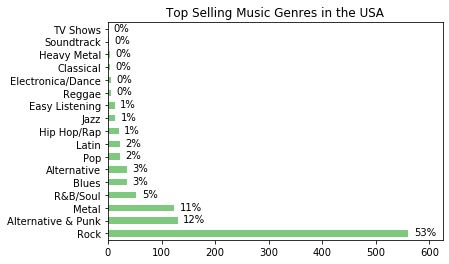

In [4]:
genres_to_purchase.set_index("genre_name", inplace=True, drop=True)

genres_to_purchase["tracks_sold"].plot.barh(
    title="Top Selling Music Genres in the USA",
    xlim=(0, 625),
    colormap=plt.cm.Accent
)

plt.ylabel("")

for i,label in enumerate(list(genres_to_purchase.index)):
    score = genres_to_purchase.loc[label, "tracks_sold"]
    label = (genres_to_purchase.loc[label, "pct_tracks_sold"] * 100).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

Seems like the three top genres in our list of genres are Punk, Blues, and Pop.  However, Pop and Hip-Hop are close, so we can't go wrong with either genre for our third pick.

It may also help sales if we can procure and sell something in the Rock genre.

## Effective Sales Agents

We have been asked to analyze the sales performance of our employees to find out who are the top performers.

In [5]:
sql = """
    SELECT e.first_name || " " || e.last_name AS employee, e.hire_date, SUM(i.total) AS total_sales
    FROM employee AS e
    INNER JOIN customer AS c ON c.support_rep_id = e.employee_id
    INNER JOIN invoice AS i ON i.customer_id = c.customer_id
    GROUP BY e.employee_id
    ORDER BY i.total DESC
"""

employee_sales = run_query(sql)
print(employee_sales)

        employee            hire_date  total_sales
0   Jane Peacock  2017-04-01 00:00:00      1731.51
1  Steve Johnson  2017-10-17 00:00:00      1393.92
2  Margaret Park  2017-05-03 00:00:00      1584.00


We have three employees out of the seven who made all of our sales.

Let's visualize our data:

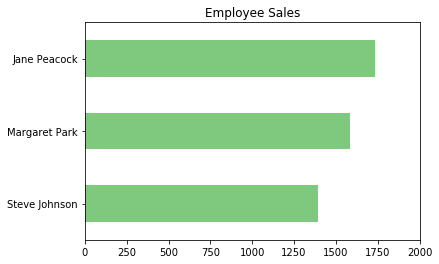

In [6]:
employee_sales.set_index("employee", inplace=True, drop=True)
employee_sales.sort_values("total_sales", inplace=True)

employee_sales["total_sales"].plot.barh(
    title="Employee Sales",
    xlim=(0, 2000),
    colormap=plt.cm.Accent
)

plt.ylabel("")

plt.show()

There seems to be a correlation between hire date and the amount of sales produced by an employee.  Jane Peacock was hired before all the other employees and has the most sales.

## Comparison of Sales by Country

We have been asked to prepare an analysis for each of teh following for each country in our sales database:

* total number of customers
* total value of sales
* average value of sales per customer
* average order value

First, we'll create a view that joins the customer, invoice, and invoice_line tables containing customer information (including country) and sales numbers.

In [7]:
customer_sales = """
    CREATE VIEW customer_sales AS
        SELECT 
            CASE 
                WHEN (
                    SELECT COUNT(*)
                    FROM customer
                    WHERE country = c.country
                    ) = 1 THEN "Other"
                ELSE c.country
            END AS country,
            c.customer_id,
            i.invoice_id,
            il.unit_price
        FROM customer AS c
        INNER JOIN invoice AS i
        ON c.customer_id = i.customer_id
        INNER JOIN invoice_line AS il
        ON i.invoice_id = il.invoice_id
        ;
"""

run_command("DROP VIEW IF EXISTS customer_sales;")
run_command(customer_sales)

Now let's create the query to calculate the values we are looking for:

In [8]:
query = """
    SELECT
        country,
        COUNT(DISTINCT customer_id) AS total_customers,
        SUM(unit_price) AS total_sales,
        SUM(unit_price) / COUNT(DISTINCT customer_id) AS avg_value_sales_per_customer,
        SUM(unit_price) / COUNT(DISTINCT invoice_id) AS avg_order_value
    FROM 
        (
          SELECT
              cs.*,
              CASE
                  WHEN cs.country = "Other" THEN 1
                  ELSE 0
              END AS sort
          FROM
            customer_sales AS cs
        )
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
"""
sales_info_by_country = run_query(query)
print(sales_info_by_country)

          country  total_customers  total_sales  avg_value_sales_per_customer  \
0             USA               13      1040.49                     80.037692   
1          Canada                8       535.59                     66.948750   
2          Brazil                5       427.68                     85.536000   
3          France                5       389.07                     77.814000   
4         Germany                4       334.62                     83.655000   
5  Czech Republic                2       273.24                    136.620000   
6  United Kingdom                3       245.52                     81.840000   
7        Portugal                2       185.13                     92.565000   
8           India                2       183.15                     91.575000   
9           Other               15      1094.94                     72.996000   

   avg_order_value  
0         7.942672  
1         7.047237  
2         7.011148  
3         7.781400  
4  

### Analysis of Total Number of Customers by Country



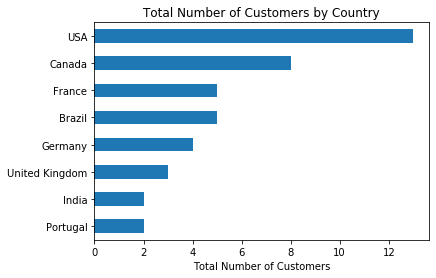

In [9]:
sales_info_by_country.set_index("country", inplace=True, drop=True)
sales_info_by_country.sort_values("total_customers", inplace=True)
sales_info_by_country[1:9]["total_customers"].plot.barh(
    title="Total Number of Customers by Country"
)

plt.ylabel("")
plt.xlabel("Total Number of Customers")

plt.show()

Based on this chart, it seems as though the United States has the most potential as far as number of customers.  With Canada as another possible target market.

### Analysis of Total Value of Sales by Country

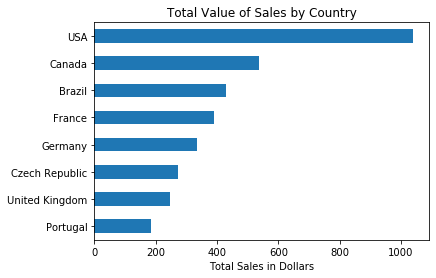

In [10]:
sales_info_by_country.sort_values("total_sales", inplace=True)
sales_info_by_country[1:9]["total_sales"].plot.barh(
    title="Total Value of Sales by Country"
)

plt.ylabel("")
plt.xlabel("Total Sales in Dollars")

plt.show()

This graph supports our previous analysis of the number of potential customers.  It makes sense that the two countries (USA, Canada) with the most customers would generate the most sales.

### Analysis of Average Value of Sales per Customer

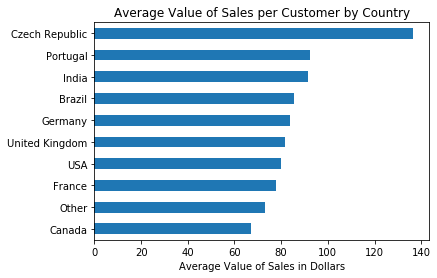

In [11]:
sales_info_by_country.sort_values("avg_value_sales_per_customer", inplace=True)
sales_info_by_country["avg_value_sales_per_customer"].plot.barh(
    title="Average Value of Sales per Customer by Country"
)

plt.ylabel("")
plt.xlabel("Average Value of Sales in Dollars")

plt.show()

According to this graph, the average sales per customer is highest in the Czech Republic, followed by India and Portugal.  This may be an indication that, although with fewer customers, they may be willing to spend more in our store than in other countries.

### Analysis of Average Order Value

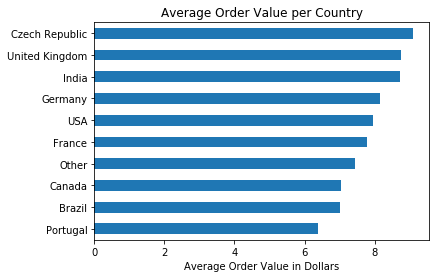

In [12]:
sales_info_by_country.sort_values("avg_order_value", inplace=True)
sales_info_by_country["avg_order_value"].plot.barh(
    title="Average Order Value per Country"
)

plt.ylabel("")
plt.xlabel("Average Order Value in Dollars")

plt.show()

The average amount spent per order in the Czech Republic, U.K., and India.  Based on this information, it may be worth considering these three countries as they are willing to spend more per purchase than any of the other countries.

## Purchase Individual Tracks vs Entire Album

Management is considering whether or not allowing customers to purchase the most popular tracks vs entire albums from record companies to save money.  When customers purchase albums, they are charged the same price as if they had purchased each of those tracks separately.

We need to consider what the effects are to changing the purchase strategy to only allowing the customer to purchase tracks.

We'll start of by providing a summary of the number and percentage of invoices that involve either purchasing an entire album vs. purchasing individual tracks from an album.

In [17]:
indiv_vs_album = """
    WITH invoice_first_track AS (
        SELECT
            il.invoice_id AS invoice_id,
            MIN(il.track_id) AS first_track_id
        FROM invoice_line AS il
        GROUP BY 1
    )
    
    SELECT
        album_purchased,
        COUNT(invoice_id) AS num_invoices,
        CAST(COUNT(invoice_id) AS FLOAT) / (SELECT COUNT(*) FROM invoice) AS pct_invoices
    FROM (
        SELECT
            ifs.*,
            CASE 
                WHEN (
                    /*
                        Select all tracks from the album of the 
                        first track purchased in the invoice.
                    */
                    SELECT t.track_id
                    FROM track AS t
                    WHERE t.album_id = (
                        SELECT t2.album_id
                        FROM track AS t2
                        WHERE t2.track_id = ifs.first_track_id
                    )
                    EXCEPT
                    /*
                        Select all the tracks purchased for a
                        particular invoice.
                    */
                    SELECT il2.track_id
                    FROM invoice_line AS il2
                    WHERE il2.invoice_id = ifs.invoice_id
                ) IS NULL 
                AND (
                    SELECT il2.track_id
                    FROM invoice_line AS il2
                    WHERE il2.invoice_id = ifs.invoice_id

                    EXCEPT

                    SELECT t.track_id
                    FROM track AS t
                    WHERE t.album_id = (
                        SELECT t2.album_id
                        FROM track AS t2
                        WHERE t2.track_id = ifs.first_track_id
                        )
                ) IS NULL
                THEN "yes"
                ELSE "no"
            END AS "album_purchased"
        FROM invoice_first_track AS ifs
    )
    GROUP BY album_purchased;
"""

run_query(indiv_vs_album)

,album_purchased,num_invoices,pct_invoices
0,no,500,0.814332
1,yes,114,0.185668


### Conclusion

Based on the above numbers, album purchases account for 18.6% of the music sales.  We wouldn't recommend only selling tracks by themselves as it could potentially taking away approximately one-fifth of sales.